# **Основная загрузка и импортирование библиотек**

In [50]:
pip install pymorphy2

In [49]:
pip install textcleaner

In [51]:
pip install wordcloud

In [52]:
pip install pyowm

In [10]:
# подключение к google диску
import os
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# импортирование библиотек для проекта
import re
import pandas as pd
import numpy as np
from datetime import datetime

from textblob import TextBlob
import pymorphy2
import collections, re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from PIL import Image

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Загрузка данных и их исследование**

In [12]:
# загрузка исходных данных
query_rank=pd.read_csv('/content/drive/MyDrive/WB_hackathon/query_popularity.csv',header=0)
query_rank.columns=['query','rank']
query_rank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336988 entries, 0 to 336987
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   query   336987 non-null  object
 1   rank    336988 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.1+ MB


In [13]:
# отображение первых строк исходного файла
query_rank.dropna(inplace=True)
query_rank=query_rank.reset_index(drop=True)

In [14]:
# проверка на уникальность поисковых запросов
query_rank['query'].unique()

array(['ноутбук', 'куртка женская осенняя', 'ботинки женские', ...,
       'Дешевый товар', 'макса', 'чехол для телефон'], dtype=object)

In [15]:
# долевая составляющая каждого ранга
ranks=query_rank['rank'].unique()
percentage=[]
for rank in ranks:
  percentage.append([rank,query_rank['rank'].value_counts()[rank]/len(query_rank)*100])
percentage=pd.DataFrame(percentage,columns=['rank','percent'])

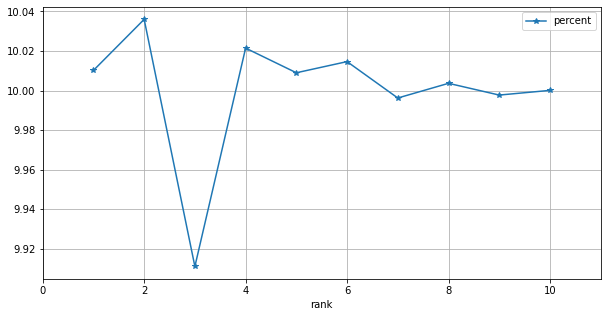

In [16]:
# визуализация долевого значения каждого ранга
percentage.plot(x='rank',y='percent',style='*-',xlim=(0,11),figsize=(10,5),grid=True);

In [83]:
# долевая составляющая количества слов в запросе
words=query_rank['cnt_words'].unique()
request=[]
for word in sorted(words):
  request.append([word,query_rank['cnt_words'].value_counts()[word]/len(query_rank)*100])
request=pd.DataFrame(request,columns=['words','percent'])

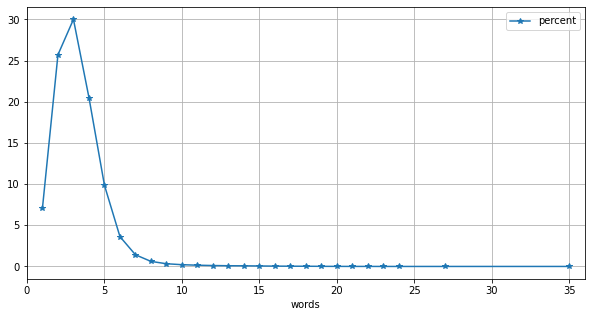

In [84]:
# визуализация долевого значения каждого ранга
request.plot(x='words',y='percent',style='*-',xlim=(0,36),figsize=(10,5),grid=True);

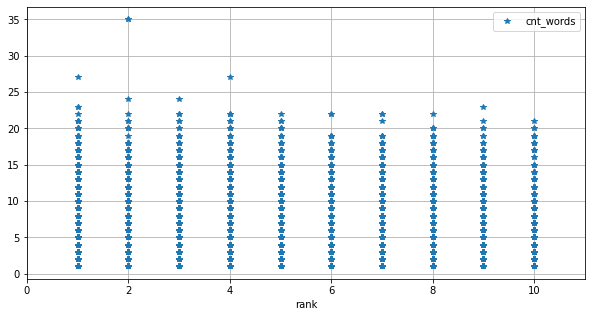

In [85]:
# визуализация долевого значения каждого ранга
query_rank.plot(x='rank',y='cnt_words',style='*',xlim=(0,11),figsize=(10,5),grid=True);

In [86]:
top_10=query_rank[query_rank['rank']==10]
top_10['cnt_words'].value_counts()[:5]

3    10941
2     8469
4     7096
1     3120
5     2972
Name: cnt_words, dtype: int64

In [87]:
outsider_2=query_rank[query_rank['rank']==2]
outsider_2['cnt_words'].value_counts()[:5]

3    10074
2     8343
4     7004
5     3537
1     1952
Name: cnt_words, dtype: int64



---


**Вывод**: длина поисковой подсказки должна быть не более 4 слов

In [89]:
# собирем мешок слов из популярных запросов (только русского алфавита без цифр)
bagsofwords = collections.Counter([y for x in query_rank['query'].values.flatten() for y in re.findall(r'[а-яА-Я]+', str(x).lower())])
#re.findall(r'[а-яА-Я]+', text.lower())
print('Размер "мешка слов" - ',len(bagsofwords))

Размер "мешка слов" -  61023


In [ ]:
morph=pymorphy2.MorphAnalyzer()
сouple_of_words=[]
for word in sorted(list(bagsofwords.keys())):
  lemma=morph.parse(word)[0]
  сouple_of_words.append([word,lemma.normal_form])
сouple_of_words

In [91]:
pair=pd.DataFrame(сouple_of_words,columns=['words','lemma'])
pair['rank']=''
for i in range (len(pair)):
  key=pair['words'][i]
  pair['rank'][i]=bagsofwords[key]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


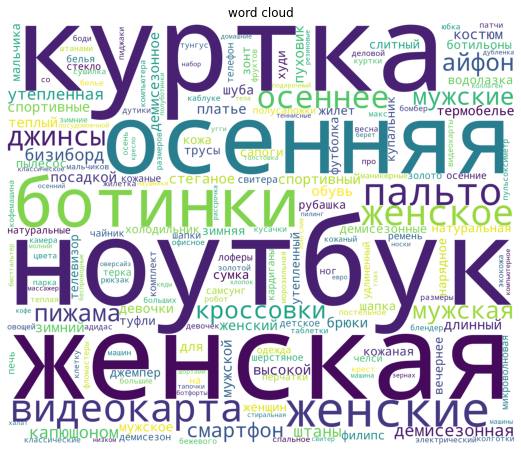

In [ ]:
# визуализация распределения слов по популярности
procWordCloud = get_wordCloud(bagsofwords)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.title("word cloud")
plt.savefig("word cloud.png") 



---
**Выводы:** в самых популярных клиентских запросах преобладают товары сезонные.


# **Работа с текстом:**
 * токенизация
 * удаление стоп-слов
 * лемматизация (приведение к начальной форме)
 * морфологическая разметка (для выделения категорий товара)

 для последующего формирования словаря

In [70]:
import textcleaner as tc
from nltk.corpus import stopwords

# создаем
def token_lemma_russ (text):
  tokens=re.findall(r'[а-яА-Я]+', str(text).lower())

  morph =pymorphy2.MorphAnalyzer()
  txt=''
  for token in tokens:
    if token not in stopwords.words('russian'):
      txt+=morph.parse(token)[0].normal_form+' '
  return txt

In [113]:
# подсчет количества слов в каждом популярном запросе
query_rank['cnt_words']=''
query_rank['words']=''
for i in range (len(query_rank)):
  text=query_rank['query'][i]
  query_rank['words'][i]=token_lemma_russ (text) 
  query_rank['cnt_words'][i]=len(str(query_rank['words'][i]).split())

In [45]:
# очистка теста токенизация и лемма
token=nltk.tokenize.WhitespaceTokenizer()
lemma=nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')

def lemma_text(text):
  return [lemma.lemmatize(w) for w in token.tokenize(text)]
query_rank['words']=query_rank['query'].apply(lemma_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [54]:
query_rank['form_norm']=''
#for i in range(len(query_rank)):
#query_rank['form_norm']=query_rank['words'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stopwords.words('russian'))]))
query_rank['form_norm']=query_rank['words'].apply(lambda x: ' '.join([word for word in x if word not in (stopwords.words('russian'))]))


In [57]:
query_rank['form_norm']=query_rank['form_norm'].str.lower()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336987 entries, 0 to 336986
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   query      336987 non-null  object
 1   rank       336987 non-null  int64 
 2   cnt_words  336987 non-null  object
 3   words      336987 non-null  object
 4   form_norm  336987 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.9+ MB


In [64]:
for i in range (len(query_rank)): 
  query_rank['cnt_words'][i]=len(query_rank['words'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
morph =pymorphy2.MorphAnalyzer()
query_rank['base']=query_rank['form_norm'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x]))

In [140]:
one_query=query_rank[(query_rank['rank']==10)&(query_rank['cnt_words']==1)]['query'].unique()
print('Доля одиночных запросов - {:.2%}'.format(len(one_query)/len(query_rank)))

Доля одиночных запросов - 0.93%


In [ ]:
query_rank['stop_words']=''
for i in range (len(query_rank)):
  text=query_rank['words'][i]
  

In [139]:
query_rank

query  ...                   form_norm
0                          ноутбук  ...                     ноутбук
1           куртка женская осенняя  ...      куртка женская осенняя
2                  ботинки женские  ...             ботинки женские
3                       видеокарта  ...                  видеокарта
4           пальто женское осеннее  ...      пальто женское осеннее
...                            ...  ...                         ...
336982  конструктор робо-динозавры  ...  конструктор робо-динозавры
336983                        чика  ...                        чика
336984               Дешевый товар  ...               дешевый товар
336985                       макса  ...                       макса
336986           чехол для телефон  ...               чехол телефон

[336987 rows x 5 columns]

In [ ]:
def lemmatizer (text):
  res=''
  words=str(text).split()
  for word in words:
    p=morph.parse(word)[0]
    res+=(p.normal_form)+' '
  return res[:-1]

In [ ]:
morph=pymorphy2.MorphAnalyzer()
query_rank['lemmas']=''
for i in range (len(query_rank)):
  text=query_rank['post_clean'][i]
  query_rank['lemmas'][i]=lemmatizer(text.lower())

# **Идея создания шаблона для поисковых рекомендация**

In [74]:
# API для поключения к https://openweathermap.org/
import pyowm
owm=pyowm.OWM('816e642439aa601255be01c741e825bf')

In [138]:
# создаем функцию для рекомендаций по сезону и погоде
def season (country):
  owm=pyowm.OWM('816e642439aa601255be01c741e825bf')
  
  mount_now=datetime.now().month
  season=['зима','весна','лето','осень']
  
  mgr = owm.weather_manager()
  observation=mgr.weather_at_place(country)
  weather = observation.weather
  temperature=weather.temperature('celsius')['temp']
  #status=weather.status    # может указывать на осадки
  #temperature=1.8

  temp_mean=[[-10,-5],[-10,-3],[-5,2],[2,11],[8,19],[12,22],[14,24],
             [12,22],[7,16],[2,8],[-3,1],[-7,-3]]
  if temp_mean[mount_now][0]>=temperature:                                            
    dop_season=season[(mount_now//3+1)%4] # предлагаем следующий сезон
  elif temperature >= temp_mean[mount_now][1]:
    dop_season='демисезонность'           # предлагаем демисезон
  else:
    dop_season=season[mount_now//3]

  if mount_now==12:
    mount_now-=12
  return season[mount_now//3], dop_season

In [133]:
# рекомендация по рейтингу продаж
def sales(query):
  #if query not in rank_sales[keys]:
    #query='разное'
  rank_sales={'куртка':{'утепленная':141,'с капюшеном':118,'кожанная':108,'удлиненная':63,'с мехом':53,'из экокожи':22,'горнолыжная':15,'с шерстью':5},
              'пальто':{'стеганное':115,'с капюшоно':74,'шерстяное':63,'длинное':61,'драповое':55,'синтепоновое':33,'пуховик':16,'классическое':10},
              'пуховик':{'длинный':50,'короткий':20,'с капюшоном':15,'с мехом':14,'мембрана':2},
              'ботинки':{'кожанные':1,'reima':15,'прорезиненная':8},
              'разное':{'кожанные':1,'reima':15,'прорезиненная':8}}
  sale_1=sorted(rank_sales[query])[-1]
  sale_2=sorted(rank_sales[query])[-2]
  sale_3=sorted(rank_sales[query])[-3]
  return  sale_1,sale_2,sale_3

In [116]:
# префиксы
perfixes=['полу']

In [118]:
# регистрация пользователя (история покупок)
registration={'gender': 'женский',
              'city':'Moscow',
              'buy':{'детский':15,'игрушка':8,'свитер':5}}

In [136]:
# запрос клиента
query=input('Поисковая строка: ')

Поисковая строка: куртка


In [137]:
# выдача рекомендованного запроса по шаблону 
#[история клиента] [запрос на сайте][сезонная рекомендация][рекомендация по продажам]

print('Поисковые рекомендации')
print('______________________')
print('{} {} {} {}'.format(registration['gender'], query,season(registration['city'])[0],sales(query)[1]))
print('{} {} {} {}'.format(registration['gender'], query,season(registration['city'])[1],sales(query)[0]))
print('{} {} {} {}'.format(registration['gender'], query,season(registration['city'])[1],sales(query)[2]))

Поисковые рекомендации
______________________
женский куртка осень удлиненная
женский куртка демисезонность утепленная
женский куртка демисезонность с шерстью
